In [ ]:
import os, csv, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score,classification_report,confusion_matrix,f1_score)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

# Simpan model
import joblib

warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
file_id = "1By-Y0rcgMuKX8EOLJ790uwJ8ggsVNZ7e"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
df = pd.read_csv(url, low_memory=False)

In [ ]:
if "Temparature" in df.columns and "Temperature" not in df.columns:
    df = df.rename(columns={"Temparature": "Temperature"})

print("Shape:", df.shape)
df.head()

Shape: (750000, 10)


,id,Temperature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   Temperature      750000 non-null  int64 
 2   Humidity         750000 non-null  int64 
 3   Moisture         750000 non-null  int64 
 4   Soil Type        750000 non-null  object
 5   Crop Type        750000 non-null  object
 6   Nitrogen         750000 non-null  int64 
 7   Potassium        750000 non-null  int64 
 8   Phosphorous      750000 non-null  int64 
 9   Fertilizer Name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB


In [ ]:
df.isnull().sum()

,0
id,0
Temperature,0
Humidity,0
Moisture,0
Soil Type,0
Crop Type,0
Nitrogen,0
Potassium,0
Phosphorous,0
Fertilizer Name,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.describe()

,id,Temperature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,216506.495284,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,0.000000,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,187499.750000,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,374999.500000,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,562499.250000,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,749999.000000,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [ ]:
crop_col = "Crop Type"
assert crop_col in df.columns, "Kolom 'Crop Type' tidak ditemukan."

# filter padi-only
paddy_mask = (
    df[crop_col].astype(str).str.strip().str.lower()
    .isin(["paddy", "rice"])
)
df = df.loc[paddy_mask].copy()

print("Total baris padi:", len(df))
print(df[crop_col].value_counts())

Total baris padi: 85754
Crop Type
Paddy    85754
Name: count, dtype: int64


In [ ]:
label_col = "Fertilizer Name"
assert label_col in df.columns, "Kolom label 'Fertilizer Name' tidak ada."

num_features = [c for c in ["Temperature","Humidity","Moisture","Nitrogen","Potassium","Phosphorous"] if c in df.columns]
cat_features = [c for c in ["Soil Type"] if c in df.columns]

X = df[num_features + cat_features].copy()
y = df[label_col].astype(str)

print("Fitur numerik:", num_features)
print("Fitur kategorikal:", cat_features)
print("Shape X:", X.shape, "| #kelas:", y.nunique())
print(y.value_counts().head())

Fitur numerik: ['Temperature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
Fitur kategorikal: ['Soil Type']
Shape X: (85754, 7) | #kelas: 7
Fertilizer Name
28-28       13264
10-26-26    12812
17-17-17    12661
14-35-14    12651
DAP         11828
Name: count, dtype: int64


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)
X_train.shape, X_valid.shape

((68603, 7), (17151, 7))

In [ ]:
num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
])

preprocess_tree = ColumnTransformer([
    ("num", num_pipe, num_features),
    ("cat", cat_pipe, cat_features),
])

clf = LGBMClassifier(objective="multiclass", n_estimators=1200, learning_rate=0.05,
                     num_leaves=63, min_child_samples=40, subsample=0.8,
                     colsample_bytree=0.8, random_state=SEED)

pipe = Pipeline([("prep", preprocess_tree), ("clf", clf)])

#  Train
pipe.fit(X_train, y_train)
pred = pipe.predict(X_valid)

macro_f1 = f1_score(y_valid, pred, average="macro")
print("macro-F1:", round(f1_score(y_valid, pred, average="macro"), 4))
print(classification_report(y_valid, pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 68603, number of used features: 7
[LightGBM] [Info] Start training from score -1.901059
[LightGBM] [Info] Start training from score -1.913724
[LightGBM] [Info] Start training from score -1.912934
[LightGBM] [Info] Start training from score -2.002200
[LightGBM] [Info] Start training from score -1.866445
[LightGBM] [Info] Start training from score -1.981052
[LightGBM] [Info] Start training from score -2.057456
macro-F1: 0.182
              precision    recall  f1-score   support

    10-26-26       0.20      0.21      0.20      2562
    14-35-14       0.20      0.20      0.20      2530
    17-17-17       0.19      0.20      0.19      2532
       20-20       0.17      0.16     

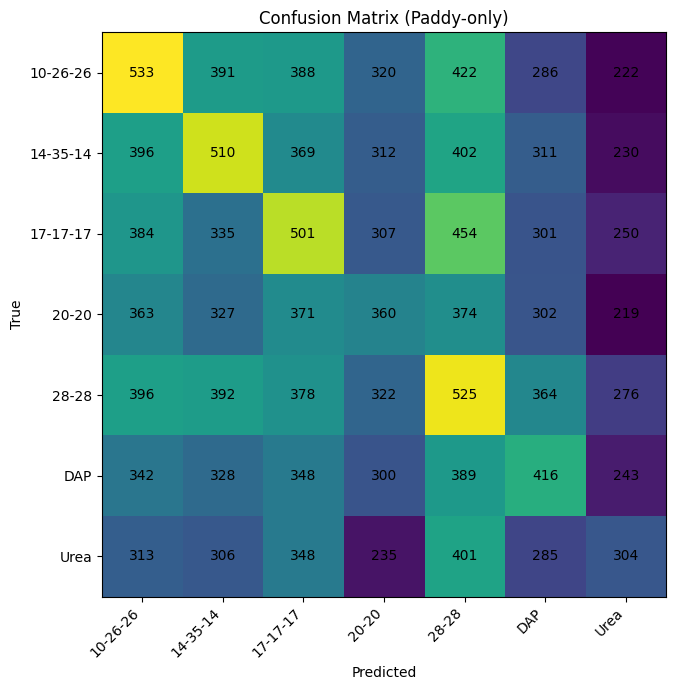

In [ ]:
# Confusion matrix
labels = sorted(y_valid.unique())
cm = confusion_matrix(y_valid, pred, labels=labels)

plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Paddy-only)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, str(cm[i,j]), ha="center", va="center")
plt.tight_layout(); plt.show()

In [ ]:
# Top-3 & MAP@3
import numpy as np
proba = pipe.predict_proba(X_valid)
classes = pipe.named_steps["clf"].classes_
top3_idx = np.argsort(-proba, axis=1)[:, :3]
top3 = classes[top3_idx]

# Top-3 accuracy
y_true = np.array(y_valid)
top3_acc = np.mean([y_true[i] in top3[i] for i in range(len(y_true))])

# MAP@3
scores = []
for i in range(len(y_true)):
    lst = list(top3[i]); scores.append(1.0/(lst.index(y_true[i])+1) if y_true[i] in lst else 0.0)
print("Top-3 Accuracy:", round(top3_acc, 4), "MAP@3:", round(float(np.mean(scores)), 4))

Top-3 Accuracy: 0.4959 MAP@3: 0.3148


In [ ]:
MODEL_PATH = "/content/fertilizer_paddy_logreg.joblib"
joblib.dump(pipe, MODEL_PATH)
print("Model disimpan ke:", MODEL_PATH)

Model disimpan ke: /content/fertilizer_paddy_logreg.joblib


In [ ]:
# Contoh ambil 3 rekomendasi untuk data baru
proba_new = pipe.predict_proba(X_valid)
top3_idx = np.argsort(-proba_new, axis=1)[:, :3]
top3_labels = classes[top3_idx]
top3_scores = np.take_along_axis(proba_new, top3_idx, axis=1)

rec_df = pd.DataFrame({
    "rec1": top3_labels[:,0], "score1": top3_scores[:,0],
    "rec2": top3_labels[:,1], "score2": top3_scores[:,1],
    "rec3": top3_labels[:,2], "score3": top3_scores[:,2],
})
rec_df.head()

,rec1,score1,rec2,score2,rec3,score3
0,17-17-17,0.264158,28-28,0.246060,10-26-26,0.118426
1,17-17-17,0.265992,20-20,0.172106,DAP,0.171611
2,28-28,0.194370,Urea,0.188944,17-17-17,0.167719
3,17-17-17,0.315325,DAP,0.240409,28-28,0.136918
4,17-17-17,0.245723,14-35-14,0.184864,Urea,0.158443
